In [ ]:
import tarfile
import zipfile
import shutil
import random
import os
import cv2
import pathlib
import numpy as np
import pandas as pd

import tensorflow as tf
import matplotlib.pyplot as plt
from numpy.random import seed
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import mixed_precision
from tensorflow.keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet101



from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import top_k_accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

import plotly.graph_objects as go
from plotly.subplots import make_subplots

from tqdm.notebook import tqdm


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
random_seed = 42
keras.utils.set_random_seed(random_seed)

In [ ]:
train_data_dir = pathlib.Path('/kaggle/input/foodx-251/clean_train80_sampling_diviso/clean_train80_sampling_diviso')
shuffle_value = True
validation_split = 0.2
batch_size = 256
seed_train_validation = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=validation_split,
    seed=seed_train_validation,
    subset="training",
    image_size=(224,224),
    batch_size=batch_size,
    shuffle=shuffle_value)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="categorical",
    validation_split=validation_split,
    seed=seed_train_validation,
    subset="validation",
    image_size=(224,224),
    batch_size=batch_size,
    shuffle=shuffle_value)

test_data_dir = pathlib.Path('/kaggle/input/foodx-251/val_set_diviso/val_set_diviso')
shuffle_value = True

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="categorical",
    subset=None,
    image_size=(224,224),
    batch_size=batch_size,
    shuffle=shuffle_value)

test_degraded_data_dir = pathlib.Path('/kaggle/input/foodx-251/val_set_degraded_diviso/val_set_degraded_diviso')
shuffle_value = True
test_degraded_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_degraded_data_dir,
    labels="inferred",
    label_mode="categorical",
    subset=None,
    image_size=(224,224),
    batch_size=batch_size,
    shuffle=shuffle_value)



Found 75300 files belonging to 251 classes.
Using 60240 files for training.
Found 75300 files belonging to 251 classes.
Using 15060 files for validation.
Found 11993 files belonging to 251 classes.
Found 11993 files belonging to 251 classes.


In [ ]:
from keras.applications.resnet50 import ResNet50, preprocess_input

def preprocess(images, labels):
    preprocessed_images = preprocess_input(images)
    return preprocessed_images, labels

train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)
test_ds = test_ds.map(preprocess)
test_degraded_ds = test_degraded_ds.map(preprocess)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=True, input_shape= (224, 224, 3))
#base_model.summary()

102967424/102967424 [==============================] - 3s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
model = Model(inputs=base_model.input, outputs=base_model.get_layer('avg_pool').output)
last_layer = base_model.get_layer('avg_pool').output
flatten_layer = Flatten()(last_layer)
classification_layer = Dense(251, activation='softmax')(flatten_layer)
model = Model(inputs=model.input, outputs=classification_layer)
#model.summary()

In [ ]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer,  metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])
history = model.fit(train_ds, epochs=20, verbose=1, validation_data=val_ds)

Epoch 1/20
236/236 [==============================] - 248s 988ms/step - loss: 5.0247 - accuracy: 0.0733 - top_k_categorical_accuracy: 0.1400 - val_loss: 4.4759 - val_accuracy: 0.1460 - val_top_k_categorical_accuracy: 0.2558
Epoch 2/20
236/236 [==============================] - 230s 961ms/step - loss: 4.1357 - accuracy: 0.2043 - top_k_categorical_accuracy: 0.3366 - val_loss: 4.0486 - val_accuracy: 0.2184 - val_top_k_categorical_accuracy: 0.3571
Epoch 3/20
236/236 [==============================] - 230s 961ms/step - loss: 3.7983 - accuracy: 0.2660 - top_k_categorical_accuracy: 0.4132 - val_loss: 3.8621 - val_accuracy: 0.2520 - val_top_k_categorical_accuracy: 0.4008
Epoch 4/20
236/236 [==============================] - 230s 962ms/step - loss: 3.6119 - accuracy: 0.3021 - top_k_categorical_accuracy: 0.4542 - val_loss: 3.7524 - val_accuracy: 0.2762 - val_top_k_categorical_accuracy: 0.4285
Epoch 5/20
236/236 [==============================] - 230s 965ms/step - loss: 3.4866 - accuracy: 0.3278 

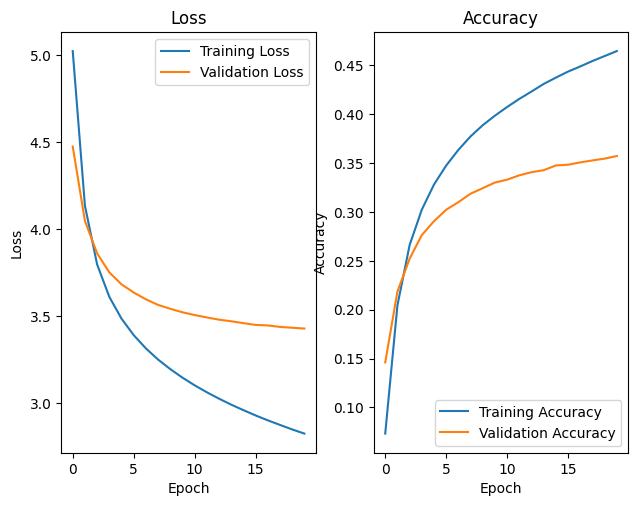

In [ ]:
def plot_performance(history):
  fig, ax = plt.subplots(1, 2)
  fig.tight_layout()
  train_acc = history.history['accuracy']
  valid_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  valid_loss = history.history['val_loss']
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Loss')
  ax[0].set_title('Loss')
  ax[0].plot(train_loss, label='Training Loss')
  ax[0].plot(valid_loss, label='Validation Loss')
  ax[0].legend()

  ax[1].set_title('Accuracy')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Accuracy')
  ax[1].plot(train_acc, label='Training Accuracy')
  ax[1].plot(valid_acc, label='Validation Accuracy')
  ax[1].legend()

  plt.show()

plot_performance(history)

In [ ]:
score = model.evaluate(test_ds, batch_size=256)
print('test loss, test acc:', score)


score = model.evaluate(test_degraded_ds, batch_size=256)
print('test loss, test acc:', score)

47/47 [==============================] - 46s 890ms/step - loss: 2.5020 - accuracy: 0.4468 - top_k_categorical_accuracy: 0.6339
test loss, test acc: [2.5020108222961426, 0.4468439817428589, 0.6338697671890259]
47/47 [==============================] - 40s 749ms/step - loss: 3.5479 - accuracy: 0.3036 - top_k_categorical_accuracy: 0.4575
test loss, test acc: [3.5479164123535156, 0.3035937547683716, 0.4575168788433075]


In [ ]:
model.save('resnet50_20ep_256batch_adagrad_avg.keras')